### Part a: Exploring the data

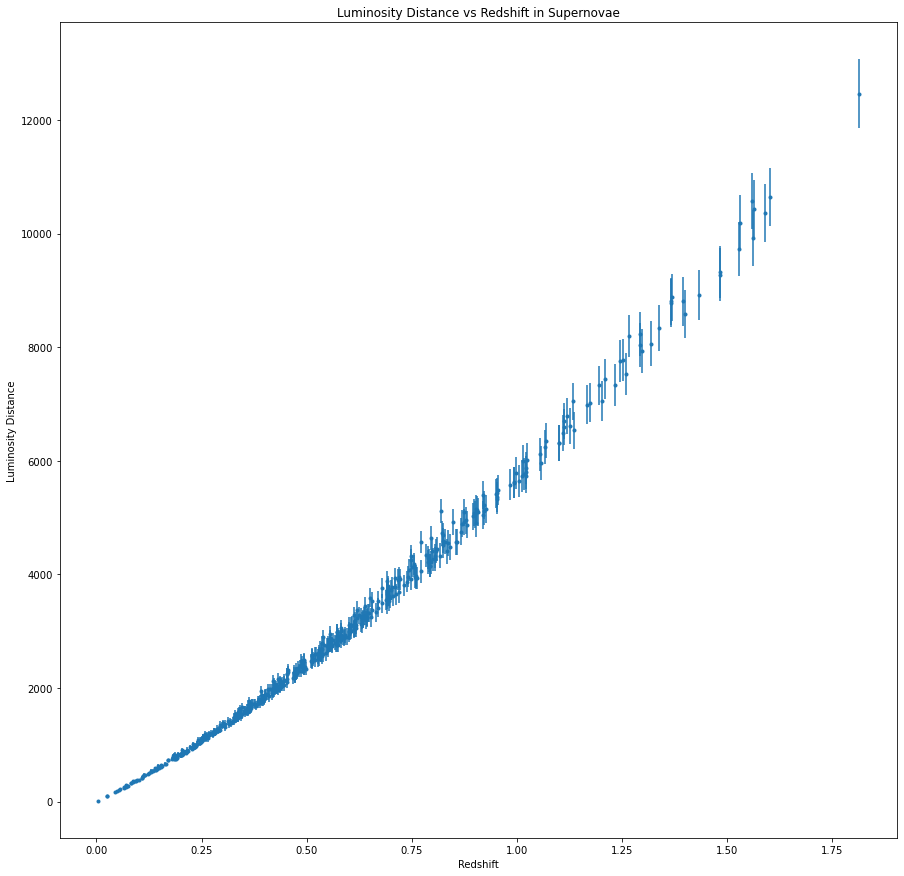

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cols = ['Redshift', 'Distance', 'Error']
obs = pd.read_csv('SN.data', names=cols, header=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.errorbar(obs['Redshift'], obs['Distance'], yerr=obs['Error'], ls='None', marker='.')
ax.set_ylabel('Luminosity Distance (Mpc)')
ax.set_xlabel('Redshift')
ax.set_title('Luminosity Distance vs Redshift in Supernovae');

We can see that error increases with redshift.

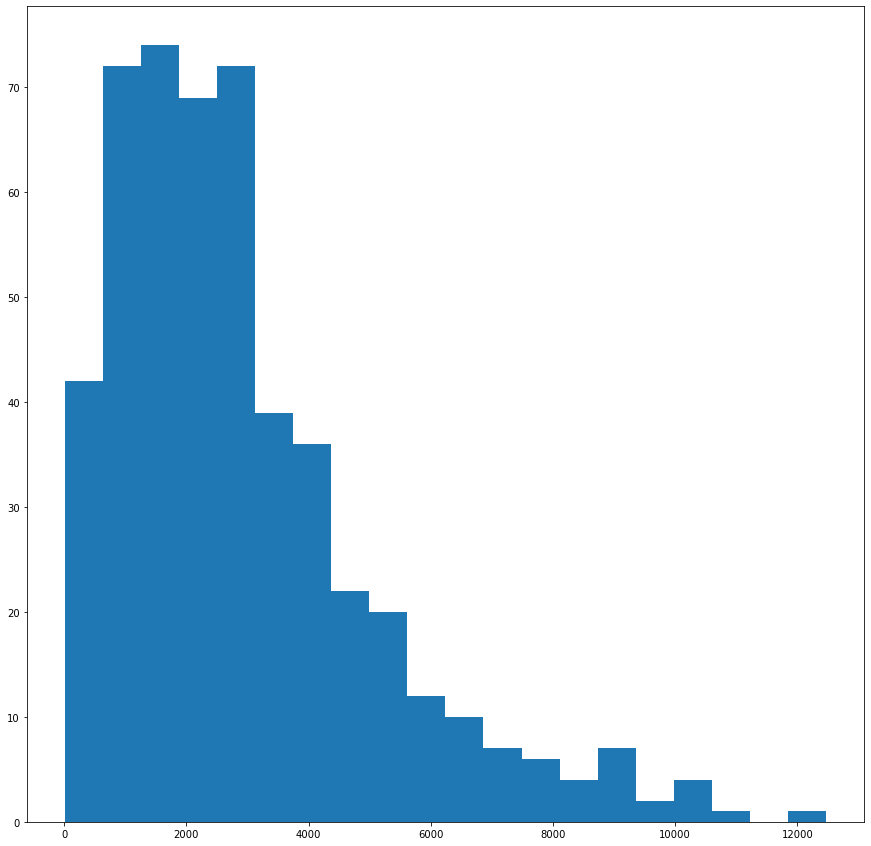

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ax.hist(obs['Distance'], bins = 20);

### Part b: Fitting a cosmological model with Markov chain Montey Carlo

Discuss choice of priors and ranges

In [7]:
from astropy.cosmology import LambdaCDM
import pymc3 as pm
import theano
import theano.tensor as t

# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

data = obs['Distance']
data_err = obs['Error']
redshifts = obs['Redshift']

@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar],otypes=[t.dvector])
def complexmodel(H0, Om0, Ode0):
    z = redshifts
    cosmo = LambdaCDM(H0=float(H0), Om0=float(Om0), Ode0=float(Ode0))
    def function(z):
        return cosmo.luminosity_distance(z).value
    
    function = function(z)
    return function

with pm.Model() as model:
    # Parameters should have uniform priors (?)
    H0 = pm.Uniform('H0', lower=40, upper=100)
    Om0 = pm.Uniform('Om0', lower=0, upper=1)
    Ode0 = pm.Uniform('Ode0',lower=0,upper=1)
    
    complexmodel=complexmodel(H0, Om0, Ode0)
    
    # TODO - actually figure out what the prior should be
    # Likelyhood of observed data
    dist = pm.Normal('LumDist', complexmodel, observed=data, sd=data_err)
    
    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Ode0]
>Metropolis: [Om0]
>Metropolis: [H0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 151 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
traces_to_pandas(traces, 1000)

,H0,Om0,Ode0
0,81.750715,0.196500,0.596369
1,81.750715,0.196500,0.596369
2,81.750715,0.195866,0.596369
3,81.750715,0.195866,0.596369
4,81.774458,0.195866,0.596369
...,...,...,...
99995,81.575544,0.202771,0.555729
99996,81.575544,0.202771,0.559545
99997,81.575544,0.202771,0.559545
99998,81.575544,0.190119,0.559545


In [29]:
# Bad code

MCMC_fit =  LambdaCDM(H0=traces['H0'][-1], Om0=traces['Om0'][-1], Ode0=traces['Ode0'][-1])
obs['Fit'] = obs.apply(lambda row: 0, axis=1)
obs['Fit_Diff'] = obs.apply(lambda row: 0, axis=1)

for index, z in enumerate(obs['Redshift']):
    obs['Fit'][index] = MCMC_fit.luminosity_distance(z).value

obs['Fit_Diff'] = obs.apply(lambda row: np.abs(row.Distance - row.Fit), axis=1)

redshifts_smooth = np.linspace(0,1.9,500)


/home/michael/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
obs


,Redshift,Distance,Error,Fit,Fit_Diff
0,0.336886,1480.919735,73.014139,1515,34.080265
1,0.186857,750.610735,37.321367,775,24.389265
2,0.442316,2088.225990,100.775470,2090,1.774010
3,0.388877,1789.298150,86.443520,1793,3.701850
4,0.181246,768.578074,36.080277,749,19.578074
...,...,...,...,...,...
495,0.140422,554.107761,27.264601,566,11.892239
496,0.919220,5040.818899,249.077286,5165,124.181101
497,0.429994,1984.276772,97.424628,2020,35.723228
498,0.239588,1014.942769,49.325590,1024,9.057231


### Part c: Estimating goodness of fit

In [11]:
from scipy.stats import chisquare

chisquare(obs.Distance, obs.Fit)

Power_divergenceResult(statistic=1188.504005097899, pvalue=3.735305573861792e-58)

### Part d: Visualization of our model

''

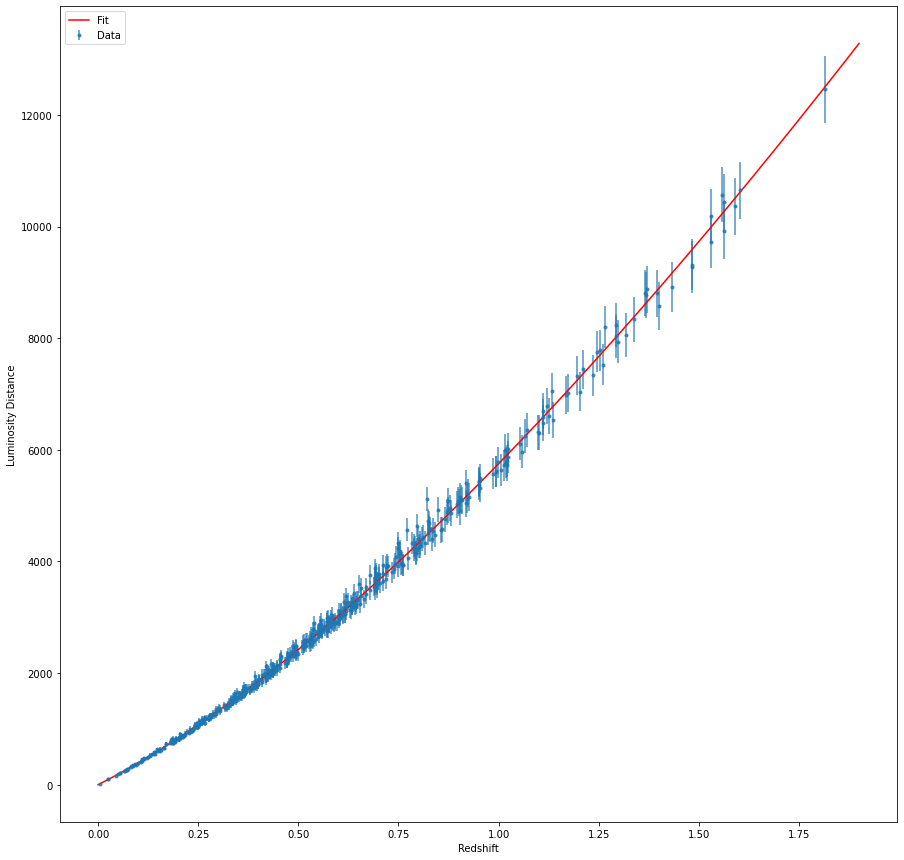

In [12]:
obs.sort_values(['Redshift'])

fig, ax = plt.subplots(figsize=(15,15))
ax.plot(redshifts_smooth, MCMC_fit.luminosity_distance(redshifts_smooth).value, ls='-', c = 'r', label='Fit')
ax.errorbar(obs['Redshift'], obs['Distance'], yerr=obs['Error'], ls='None', marker='.', alpha=.8, label='Data')
ax.set_ylabel('Luminosity Distance')
ax.set_xlabel('Redshift')
ax.legend()

;

### Part e: Visualizing uncertainty

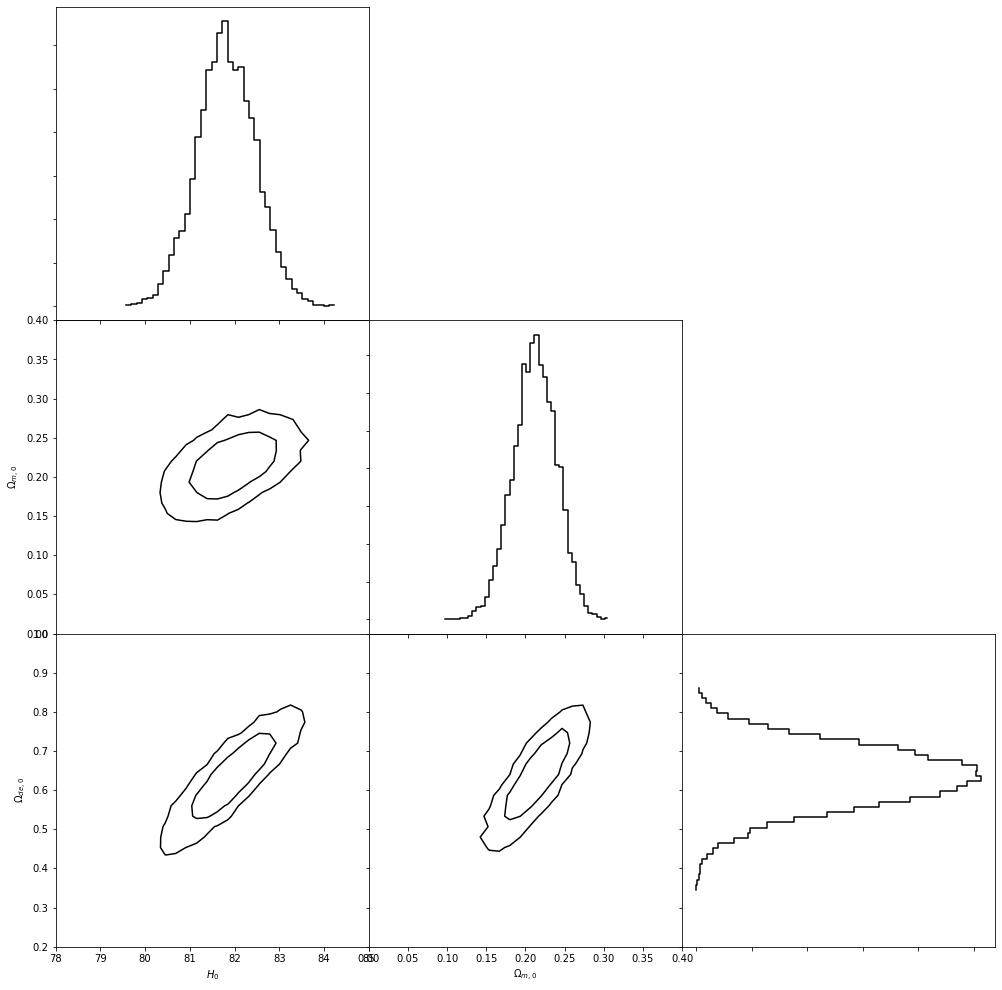

In [133]:
from astroML.plotting import hist, plot_mcmc

df = traces_to_pandas(traces, 1000)

variables = ['H0', 'Om0', 'Ode0']
labels = ['$H_0$', '$\Omega_{m,0}$', '$\Omega_{de,0}$']
limits = [(78, 85), (0, 0.4), (0.2, 1)]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits, fig=fig, bins=30, colors='k')

# compute histogram of results to plot below
L_MCMC, H0_bins, Om0_bins = np.histogram2d(traces['H0'],
                                             traces['Om0'],
                                             bins=(40,40))

L_MCMC, Om0_bins, Ode0_bins = np.histogram2d(traces['Om0'],
                                             traces['Ode0'],
                                             bins=(40,40))

L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

hist_H0, bins_H0 = np.histogram(traces['H0'], bins=H0_bins, density=True)
hist_Om0, bins_Om0 = np.histogram(traces['Om0'],bins=Om0_bins, density=True)
hist_Ode0, bins_Ode0 = np.histogram(traces['Ode0'], bins=Ode0_bins, density=True)

# plotting the histograms
ax2 = fig.add_axes((0.08, .95, 0.435, 0.435))
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(0.5 * (bins_H0[1:] + bins_H0[:-1]
                            - bins_H0[1] + bins_H0[0]),hist_H0, 
         '-k', drawstyle='steps')
ax2.set_xlim(limits[0])
ax2.xaxis.set_ticklabels([])

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.515, 0.515, 0.435, 0.435))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_Om0[1:] + bins_Om0[:-1]
                                        - bins_Om0[1] + bins_Om0[0]), hist_Om0, 
         '-k', drawstyle='steps-mid')
ax3.set_xlim(limits[1])
ax3.xaxis.set_ticklabels([])

# third axis: marginalized over gamma
ax4 = fig.add_axes((.95, 0.08, 0.435, 0.435))
ax4.xaxis.set_major_formatter(plt.NullFormatter())
ax4.plot( hist_Ode0, 0.5 * (bins_Ode0[1:] + bins_Ode0[:-1]),
         '-k', drawstyle='steps-mid')
ax4.set_ylim(limits[2])
ax4.yaxis.set_ticklabels([])

plt.show()


<BarContainer object of 500 artists>

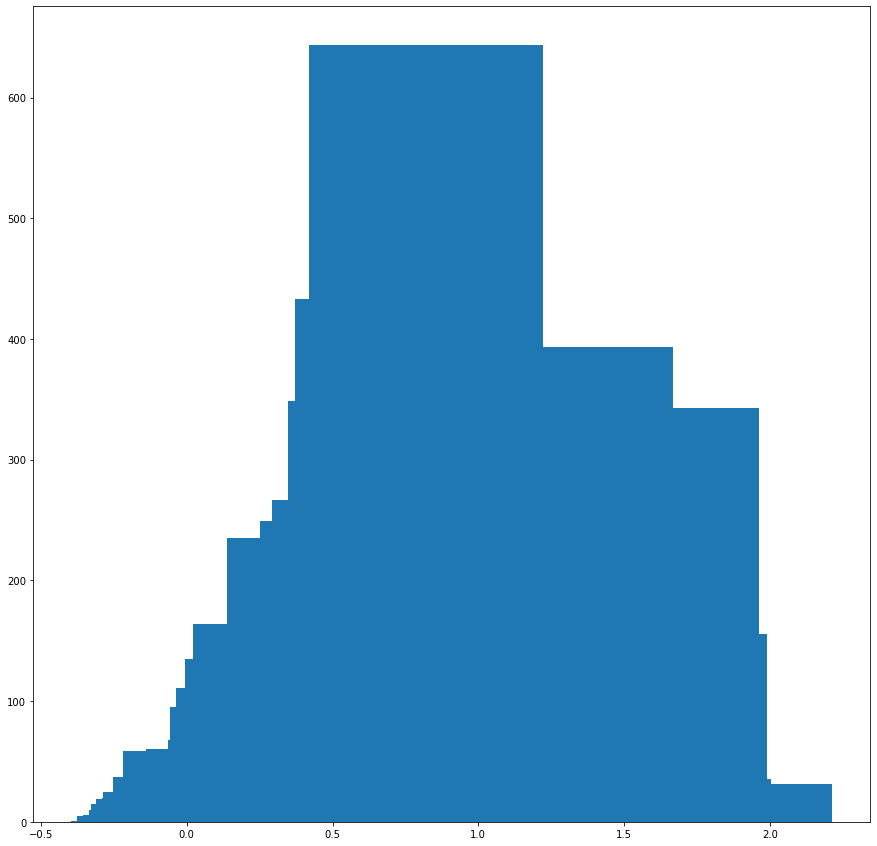

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
ax.bar(obs['Redshift'], obs['Fit_Diff'])

<BarContainer object of 500 artists>

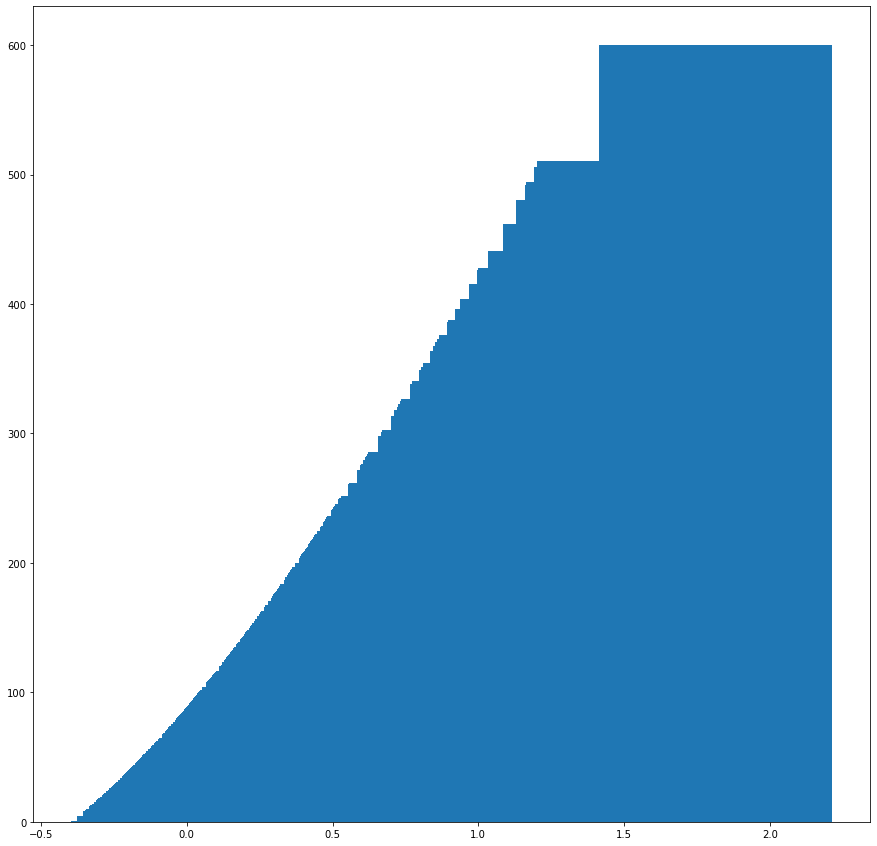

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
ax.bar(obs['Redshift'], obs['Error'])